In [154]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML


# def summary():

#     query = """
#     with test as (
#     SELECT  o.test_id,
#             date_trunc(o.created_date, ISOWEEK) WEEK,
#             o.test_variant,
#             o.perseus_client_id,
#             count( distinct o.order_id) orders
#     FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
#     where o.test_id = 77 and o.entity_id = 'AP_PA' and o.created_date >= '2023-01-01'
#     group by 1,2,3,4
#     )
#     select test_id,
#            WEEK,
#            test_variant,
#            avg(orders) avg_orders_per_user,
#            STDDEV_SAMP(orders)
#     from test
#     group by 1,2,3
#     """

#     return query

# def summary():

#     query = """
#     SELECT  o.test_id,
#             --date_trunc(o.created_date, MONTH) MONTH,
#             date_trunc(o.created_date, ISOWEEK) WEEK,
#             o.test_variant,
#             o.perseus_client_id,
#             count( distinct o.order_id) orders,
#             count( distinct o.order_id) / 7 orders_per_day_user
#     FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
#     where o.test_id = 77 and o.entity_id = 'AP_PA' and o.created_date >= '2023-01-01'
#     group by 1,2,3,4
#     """

#     return query


def summary():

    query = """
    WITH subquery AS (
    SELECT 
        o.entity_id,
        o.test_id,
        o.test_variant,
        o.perseus_client_id,
        MIN(DATE_TRUNC(o.created_date, ISOWEEK)) AS start_week, 
        MAX(DATE_TRUNC(o.created_date, ISOWEEK)) AS end_week
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
    WHERE o.test_id = 109 
      AND o.entity_id = 'AP_PA' 
      AND o.created_date >= '2023-01-01'
    GROUP BY 1, 2, 3, 4
    ),
    distinct_weeks AS (
        SELECT 
            perseus_client_id,
            entity_id,
            test_variant,
            MAX(end_week) AS end_week  -- Take the maximum end_week across all test_variants
        FROM subquery
        GROUP BY perseus_client_id, entity_id, test_variant
    )
    SELECT  
        DATE_TRUNC(o.created_date, ISOWEEK) AS week,
        o.perseus_client_id,
        d.test_variant,
        d.end_week AS end_week,  -- Use end_week from the distinct_weeks subquery
        COUNT(DISTINCT o.order_id) AS orders,
        COUNT(DISTINCT o.order_id) / 7 AS order_frequency
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
    INNER JOIN distinct_weeks d 
        ON o.perseus_client_id = d.perseus_client_id 
        AND o.entity_id = d.entity_id
        AND o.test_variant = d.test_variant
    WHERE 
        DATE_TRUNC(o.created_date, ISOWEEK) >= d.end_week - INTERVAL 12 WEEK
        AND DATE_TRUNC(o.created_date, ISOWEEK) <= DATE_ADD(d.end_week, INTERVAL 12 WEEK)
    GROUP BY 1, 2, 3, 4

    """

    return query


# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)


a = client.query(summary()).to_dataframe()

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [155]:
a['end_week'].unique()

<DateArray>
[datetime.date(2024, 6, 24), datetime.date(2024, 6, 10),
 datetime.date(2024, 6, 17), datetime.date(2024, 7, 22),
 datetime.date(2024, 7, 15), datetime.date(2024, 7, 29),
  datetime.date(2024, 7, 1),  datetime.date(2024, 7, 8)]
Length: 8, dtype: dbdate

In [140]:
# Create the pivot table
pivot_table = pd.pivot_table(match_details_df, values='orders', index=['week', 'test_variant'], aggfunc=[np.mean, np.std]).reset_index()

# Flatten the hierarchical columns
pivot_table.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_table.columns]

# Display the resulting pivot table
print(pivot_table)

         week_ test_variant_  mean_orders  std_orders
0   2024-06-10       Control     1.746032    1.456643
1   2024-06-10    Variation1     1.814664    1.549742
2   2024-06-10    Variation2     1.803297    1.397315
3   2024-06-17       Control     1.628395    1.323294
4   2024-06-17    Variation1     1.632687    1.322344
5   2024-06-17    Variation2     1.579668    1.306052
6   2024-06-24       Control     1.622322    1.320662
7   2024-06-24    Variation1     1.595497    1.275483
8   2024-06-24    Variation2     1.597238    1.291851
9   2024-07-01       Control     1.611773    1.375396
10  2024-07-01    Variation1      1.58376     1.31755
11  2024-07-01    Variation2     1.654623    1.361848
12  2024-07-08       Control     1.642666    1.383483
13  2024-07-08    Variation1     1.622549    1.336482
14  2024-07-08    Variation2     1.632472    1.362633
15  2024-07-15       Control     1.633975    1.397226
16  2024-07-15    Variation1     1.644117    1.373019
17  2024-07-15    Variation2

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_15173/3698133466.py:2: FutureWarning: The provided callable <function mean at 0x1109f7880> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = pd.pivot_table(match_details_df, values='orders', index=['week', 'test_variant'], aggfunc=[np.mean, np.std]).reset_index()
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_15173/3698133466.py:2: FutureWarning: The provided callable <function std at 0x1109f79c0> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  pivot_table = pd.pivot_table(match_details_df, values='orders', index=['week', 'test_variant'], aggfunc=[np.mean, np.std]).reset_index()


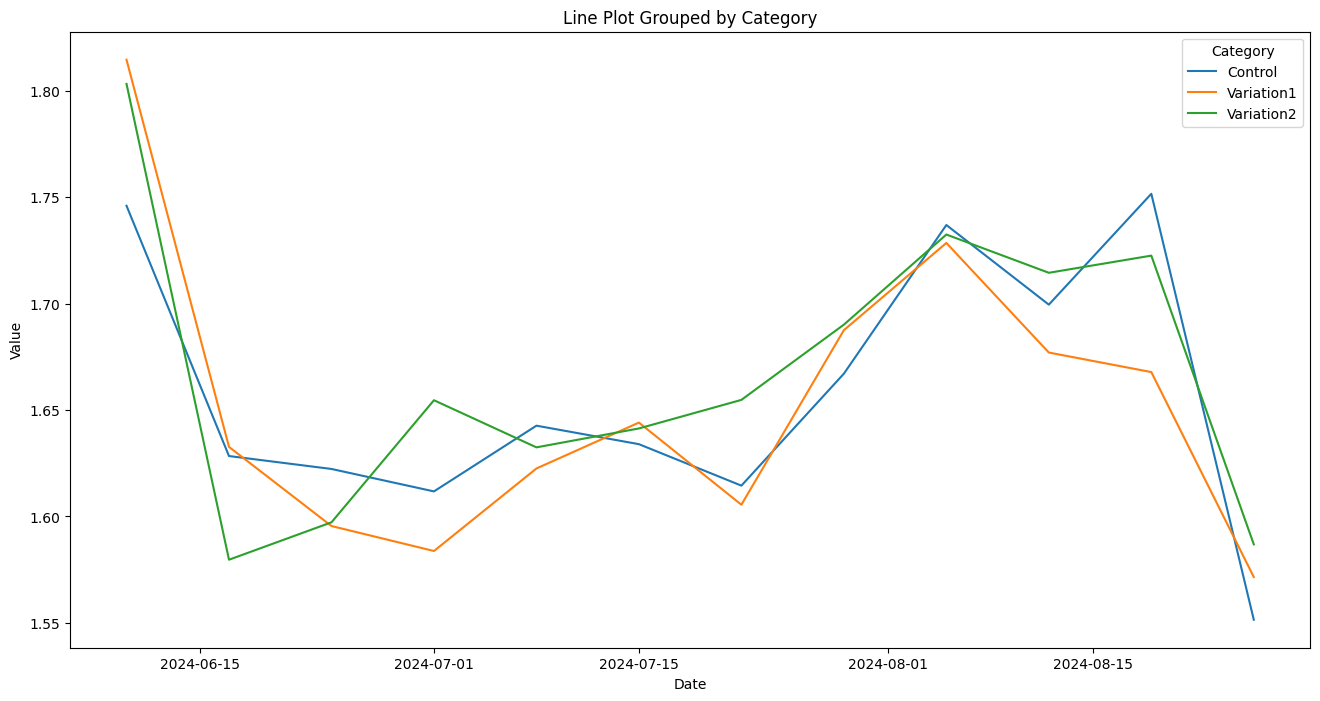

In [141]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(16, 8))  # Adjust the width and height as needed


# Plotting with Seaborn
sns.lineplot(data=pivot_table, x='week_', y='mean_orders', hue='test_variant_')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Line Plot Grouped by Category')
plt.legend(title='Category')
plt.show()

In [116]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the baseline and multiple post-treatment periods
baseline_period = ['2023-07-17']
post_treatment_periods = ['2023-07-24', '2023-07-31', '2023-08-07', '2023-08-14', '2023-08-21', '2023-08-28', '2023-09-04', '2023-09-11']

# Prepare a list to store DiD estimates
did_estimates = []

# Loop over each post-treatment period
for post_period in post_treatment_periods:
    # Create a binary indicator for the current post-treatment period
    match_details_df['post_treatment'] = match_details_df['WEEK'].apply(lambda x: 1 if x == post_period else (0 if x in baseline_period else None))
    
    # Filter the DataFrame to include only the relevant weeks (baseline and the current post-treatment period)
    tmp = match_details_df.dropna(subset=['post_treatment'])

    # Print out the filtered data for debugging
    print(f"\nFiltered data for post-period {post_period}:")
    print(tmp.head())

    # Check if the groups have data for both periods (baseline and post-treatment)
    if tmp['post_treatment'].nunique() < 2:
        print(f"Skipping period {post_period} due to insufficient data.")
        did_estimates.append(None)
        continue
    
    # Calculate the average outcome for each group in each period
    avg_outcomes = tmp.groupby(['test_variant', 'post_treatment'])['orders'].mean().unstack(fill_value=0)
    
    # Calculate the DiD estimate for the current period
    control_pre = avg_outcomes.at['Control', 0]
    control_post = avg_outcomes.at['Control', 1]
    treatment_pre = avg_outcomes.at['Variation1', 0]
    treatment_post = avg_outcomes.at['Variation1', 1]

    did_estimate = (treatment_post - treatment_pre) - (control_post - control_pre)
    
    # Store the result
    did_estimates.append(did_estimate)

# Create a DataFrame to store the results for easier visualization
results_df = pd.DataFrame({
    'Week': post_treatment_periods,
    'DiD_Estimate': did_estimates
})

# Plot the DiD estimates over time
plt.figure(figsize=(10, 6))
plt.plot(results_df['Week'], results_df['DiD_Estimate'], marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Difference-in-Difference Estimates Over Time')
plt.xlabel('Week')
plt.ylabel('DiD Estimate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


KeyError: 'WEEK'

In [86]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Filter the dataframe
tmp = match_details_df[match_details_df['test_variant'].isin(['Control', 'Variation1'])]

# Simplify by aggregating weeks into months or a similar larger time period
tmp['MONTH'] = pd.to_datetime(tmp['WEEK']).dt.to_period('M').astype(str)

# Run the model with the simplified 'MONTH' instead of 'WEEK'
model = ols('avg_orders_per_user ~ C(test_variant, Treatment(reference="Control")) * C(MONTH)', data=tmp).fit()
summary = model.summary()
print(summary)

                             OLS Regression Results                            
Dep. Variable:     avg_orders_per_user   R-squared:                       0.422
Model:                             OLS   Adj. R-squared:                  0.216
Method:                  Least Squares   F-statistic:                     2.046
Date:                 Sun, 01 Sep 2024   Prob (F-statistic):              0.134
Time:                         21:59:52   Log-Likelihood:                 24.956
No. Observations:                   20   AIC:                            -37.91
Df Residuals:                       14   BIC:                            -31.94
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_15173/3303267911.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['MONTH'] = pd.to_datetime(tmp['WEEK']).dt.to_period('M').astype(str)


In [85]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Prepare the data
X = tmp[['test_variant', 'WEEK']]
y = tmp['avg_orders_per_user']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Apply Ridge regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Check the coefficients
print(ridge.coef_)
print(ridge.intercept_)

[ 0.04388691  0.02316157  0.02215368  0.05110094  0.00330984  0.01773178
  0.01058581  0.05057235  0.02691384 -0.15914883]
1.240589313574189


In [72]:
import pandas as pd
import numpy as np
from scipy.stats import bernoulli

# Create the pivot table
pivot_table = pd.pivot_table(match_details_df, values='orders_per_day_user', index=['WEEK', 'test_variant'], aggfunc=[np.mean, np.std]).reset_index()

# Flatten the hierarchical columns
pivot_table.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_table.columns]

# Display the resulting pivot table
print(pivot_table)

         WEEK_ test_variant_  mean_orders_per_day_user  \
0   2023-07-10       Control                  0.182383   
1   2023-07-10    Variation1                  0.176871   
2   2023-07-10    Variation2                  0.180839   
3   2023-07-17       Control                  0.180748   
4   2023-07-17    Variation1                  0.189902   
5   2023-07-17    Variation2                  0.173176   
6   2023-07-24       Control                  0.183975   
7   2023-07-24    Variation1                  0.186243   
8   2023-07-24    Variation2                  0.186494   
9   2023-07-31       Control                  0.189232   
10  2023-07-31    Variation1                  0.193392   
11  2023-07-31    Variation2                  0.175676   
12  2023-08-07       Control                  0.187229   
13  2023-08-07    Variation1                  0.184442   
14  2023-08-07    Variation2                  0.199877   
15  2023-08-14       Control                  0.175466   
16  2023-08-14

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_15173/3341791011.py:6: FutureWarning: The provided callable <function mean at 0x1109f7880> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = pd.pivot_table(match_details_df, values='orders_per_day_user', index=['WEEK', 'test_variant'], aggfunc=[np.mean, np.std]).reset_index()
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_15173/3341791011.py:6: FutureWarning: The provided callable <function std at 0x1109f79c0> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  pivot_table = pd.pivot_table(match_details_df, values='orders_per_day_user', index=['WEEK', 'test_variant'], aggfunc=[np.mean, np.std]).reset_index()


In [73]:
# Assuming match_details_df is already loaded and includes columns: 'WEEK', 'test_variant', and 'orders'

# Get the unique weeks
weeks = match_details_df['WEEK'].unique()

# Dictionary to store results
results = {}

# Perform t-test and calculate confidence intervals for each week
for week in weeks:
    # Filter data for the current week
    week_data = match_details_df[match_details_df['WEEK'] == week]
    
    # Get the control and variant orders
    control = week_data[week_data['test_variant'] == 'Control']['orders_per_day_user']
    variant = week_data[week_data['test_variant'] == 'Variation2']['orders_per_day_user']
    
    # Calculate the mean, variance, and number of records for each group
    control_mean = np.mean(control)
    control_variance = np.var(control, ddof=1)
    control_n = len(control)
    
    variant_mean = np.mean(variant)
    variant_variance = np.var(variant, ddof=1)
    variant_n = len(variant)
    
    # Perform the t-test
    t_stat, p_value = stats.ttest_ind(control, variant, equal_var=False)  # Welch's t-test
    
    # Calculate the difference in means
    mean_diff = control_mean - variant_mean
    
    # Calculate the standard error of the difference
    se_diff = np.sqrt(control_variance/control_n + variant_variance/variant_n)
    
    # Degrees of freedom approximation for Welch's t-test
    df = (se_diff**4) / (((control_variance/control_n)**2 / (control_n - 1)) + 
                         ((variant_variance/variant_n)**2 / (variant_n - 1)))
    
    # Critical t value for 95% confidence interval
    t_critical = stats.t.ppf(1 - 0.025, df)
    
    # Calculate the confidence interval
    ci_lower = mean_diff - t_critical * se_diff
    ci_upper = mean_diff + t_critical * se_diff
    
    # Store the results in the dictionary
    results[week] = {
        'control_mean': control_mean,
        'control_variance': control_variance,
        'control_n': control_n,
        'variant_mean': variant_mean,
        'variant_variance': variant_variance,
        'variant_n': variant_n,
        't_stat': t_stat, 
        'p_value': p_value, 
        'mean_diff': mean_diff, 
        'ci_lower': ci_lower, 
        'ci_upper': ci_upper
    }

# Convert the results dictionary to a DataFrame for better display
results_df = pd.DataFrame.from_dict(results, orient='index')

# Display the results
results_df

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,control_mean,control_variance,control_n,variant_mean,variant_variance,variant_n,t_stat,p_value,mean_diff,ci_lower,ci_upper
2023-07-10,0.182383,0.010093,253,0.180839,0.013919,252,0.158288,0.874295,0.001544,-0.017620,0.020707
2023-07-17,0.180748,0.013094,279,0.173176,0.006224,278,0.909420,0.363572,0.007572,-0.008787,0.023931
2023-07-24,0.183975,0.009490,271,0.186494,0.009261,275,-0.303901,0.761319,-0.002519,-0.018800,0.013762
2023-07-31,0.189232,0.016874,268,0.175676,0.007083,296,1.454364,0.146543,0.013557,-0.004762,0.031876
2023-08-07,0.187229,0.014474,264,0.199877,0.018462,233,-1.092353,0.275241,-0.012648,-0.035401,0.010105
2023-08-14,0.175466,0.006873,276,0.171930,0.004613,285,0.551626,0.581437,0.003536,-0.009056,0.016128
2023-08-21,0.180272,0.012456,294,0.178082,0.007311,292,0.266735,0.789773,0.002190,-0.013937,0.018317
2023-08-28,0.183459,0.011496,285,0.193913,0.017089,291,-1.050338,0.294018,-0.010454,-0.030004,0.009096
2023-09-04,0.182231,0.011181,283,0.183280,0.007972,311,-0.129912,0.896683,-0.001049,-0.016902,0.014805
2023-09-11,0.142857,0.000000,24,0.163265,0.004665,21,-1.369306,0.186085,-0.020408,-0.051497,0.010681


In [58]:
import pandas as pd
from scipy import stats
import numpy as np

# Assuming match_details_df is already loaded and includes columns: 'test_variant' and 'orders'

# Filter the control and variant orders across all data
control = match_details_df[match_details_df['test_variant'] == 'Control']['orders']
variant = match_details_df[match_details_df['test_variant'] == 'Variation1']['orders']

# Perform the t-test
t_stat, p_value = stats.ttest_ind(control, variant, equal_var=False)  # Welch's t-test

# Calculate the difference in means
mean_diff = np.mean(control) - np.mean(variant)

# Calculate the standard error of the difference
se_diff = np.sqrt(np.var(control, ddof=1)/len(control) + np.var(variant, ddof=1)/len(variant))

# Degrees of freedom approximation for Welch's t-test
df = (se_diff**4) / (((np.var(control, ddof=1)/len(control))**2 / (len(control) - 1)) + 
                     ((np.var(variant, ddof=1)/len(variant))**2 / (len(variant) - 1)))

# Critical t value for 95% confidence interval
t_critical = stats.t.ppf(1 - 0.025, df)

# Calculate the confidence interval
ci_lower = mean_diff - t_critical * se_diff
ci_upper = mean_diff + t_critical * se_diff

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
print(f"Mean Difference: {mean_diff}")
print(f"95% Confidence Interval: ({ci_lower}, {ci_upper})")

T-statistic: -2.082062747010064
P-value: 0.03738690633605214
Mean Difference: -0.04451149341739358
95% Confidence Interval: (-0.08642272473352303, -0.002600262101264135)


In [156]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Parameters
n_users = 1000  # Number of users per group
n_days = 63     # Number of days in the long-term measurement
n_test_arms = 3 # Number of test arms including control

# Simulate user data
np.random.seed(42)

# Random baseline values for control and treatment groups
control_values = np.random.normal(loc=10, scale=2, size=(n_users, n_days))
treatment_values = [control_values + np.random.normal(loc=effect, scale=1, size=(n_users, n_days)) 
                    for effect in np.linspace(0.5, 2.0, n_test_arms-1)]

# Combine into a single dataset
data = np.concatenate([control_values] + treatment_values, axis=0)
labels = np.array([0] * n_users + [1] * n_users * (n_test_arms-1))

# Create a DataFrame for convenience
df = pd.DataFrame(data)
df['group'] = labels

# Step 2: Direct Measurement of Long-Term Treatment Effect
# Calculate long-term treatment effects
mean_outcomes = df.groupby('group').mean().mean(axis=1)
control_mean = mean_outcomes[0]

treatment_effects = mean_outcomes[1:] - control_mean
print("Direct Measurement of Long-Term Treatment Effects:")
print(treatment_effects)

# Step 3: Surrogate Index Model
# Use the first T days (e.g., 30 days) as the short-term observation period
T = 30
X = df.iloc[:, :T].values
y = df.iloc[:, T:].mean(axis=1).values

# Train a linear regression model (auto-surrogate)
model = LinearRegression()
model.fit(X, y)

# Predict long-term outcomes using the surrogate model
df['predicted_long_term'] = model.predict(X)

# Calculate treatment effects based on the predicted values
predicted_mean_outcomes = df.groupby('group')['predicted_long_term'].mean()
predicted_treatment_effects = predicted_mean_outcomes[1:] - predicted_mean_outcomes[0]

print("Surrogate Model Predicted Long-Term Treatment Effects:")
print(predicted_treatment_effects)

# Step 4: Comparison and Conclusion
# Compare the results
comparison_df = pd.DataFrame({
    'Direct Measurement': treatment_effects.values,
    'Surrogate Model': predicted_treatment_effects.values
}, index=[f'Test Arm {i}' for i in range(1, n_test_arms)])

print("Comparison of Treatment Effects:")
print(comparison_df)


Direct Measurement of Long-Term Treatment Effects:
group
1    1.250687
dtype: float64
Surrogate Model Predicted Long-Term Treatment Effects:
group
1    1.006062
Name: predicted_long_term, dtype: float64
Comparison of Treatment Effects:
            Direct Measurement  Surrogate Model
Test Arm 1            1.250687         1.006062
Test Arm 2            1.250687         1.006062


In [157]:
df

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,group,predicted_long_term
0,10.993428,9.723471,11.295377,13.046060,9.531693,9.531726,13.158426,11.534869,9.061051,11.085120,...,11.862560,8.321565,9.381575,10.662527,11.951090,9.041652,9.628682,7.787330,0,9.515295
1,7.607587,11.625052,12.712480,9.855980,12.007066,10.723272,8.709760,10.722791,13.076073,9.928348,...,12.285646,11.503866,11.582064,8.181225,12.805589,7.196298,11.173714,14.380911,0,10.086337
2,8.018927,8.867405,10.199303,8.993049,6.898673,10.137126,7.875393,10.947185,8.161152,13.099869,...,8.285685,7.858215,10.964945,9.553074,11.428001,10.946475,9.854342,8.306413,0,9.532167
3,6.970306,9.106970,11.712798,10.428187,7.508522,10.346362,10.770635,8.232285,10.307450,10.116417,...,7.599407,9.330998,9.050109,8.693342,13.530908,10.809963,7.478232,11.835724,0,10.063533
4,14.244312,12.064931,6.961260,9.031532,12.533822,8.584661,10.887639,11.549268,8.146139,9.880949,...,8.816857,11.094195,9.595615,9.564638,12.197554,11.650833,11.627019,12.610958,0,9.775990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,11.204400,11.960793,16.980021,10.982873,11.068645,14.672329,14.040720,10.427421,10.195248,14.226144,...,13.195523,8.700900,12.085252,9.663790,10.597221,7.950918,16.978509,11.536265,1,11.606824
2996,13.198506,12.379846,13.229961,15.004590,13.769289,12.789681,15.874470,9.855447,11.365619,12.496590,...,13.761928,9.018362,15.877147,13.997813,10.690251,8.999805,9.536496,14.565494,1,11.785561
2997,13.085749,12.930675,7.293679,14.185292,5.896032,8.001215,14.505585,9.108154,13.212275,12.733345,...,13.574177,11.632057,14.717661,8.342184,8.698509,13.039016,12.094442,12.051455,1,11.002490
2998,13.095783,11.982246,9.790455,14.979201,13.746853,14.968992,13.868734,12.724396,12.907898,14.178253,...,13.228993,12.338174,15.395153,13.714175,7.554679,16.065867,12.797555,10.307427,1,11.523295
